In [1]:
import numpy as np 
import pandas as pd 

from sklearn.model_selection import train_test_split, KFold, cross_val_score, RepeatedKFold,GridSearchCV
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt

In [2]:
# The data includes all features
df = pd.read_csv("../clean_data.csv", index_col=0)

In [3]:
df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,ExterQual,ExterCond,BsmtQual,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,3,2,4,...,0,0,0,0,1,0,0,0,1,0
2,20,80.0,9600,6,8,1976,1976,2,2,4,...,0,0,0,0,1,0,0,0,1,0
3,60,68.0,11250,7,5,2001,2002,3,2,4,...,0,0,0,0,1,0,0,0,1,0
4,70,60.0,9550,7,5,1915,1970,2,2,3,...,0,0,0,0,1,0,0,0,0,0
5,60,84.0,14260,8,5,2000,2000,3,2,4,...,0,0,0,0,1,0,0,0,1,0


## Identify and Remove Outliers

In [13]:
# function to detect outliers based on the predictions of a model
def find_outliers(model, df, sigma=3):

    X = df.drop("SalePrice", axis=1)
    y = np.log(df['SalePrice'])

    model.fit(X,y)
    y_pred = pd.Series(model.predict(X), index=y.index)
        
    # calculate residuals between the model prediction and true y values
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()

    # calculate z statistic, define outliers to be where |z|>sigma
    z = (resid - mean_resid)/std_resid    
    outliers = z[abs(z)>sigma].index
    
    print('R2=',model.score(X,y))
    print('rmse=',mean_absolute_error(y, y_pred))
    print('---------------------------------------')

    print('mean of residuals:',mean_resid)
    print('std of residuals:',std_resid)
    print('---------------------------------------')

    print(len(outliers),'outliers:')
    print(outliers.tolist())

    plt.plot(y,y_pred,'.')
    plt.plot(y.loc[outliers],y_pred.loc[outliers],'ro')
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('y')
    plt.ylabel('y_pred');
    
    return outliers

R2= 0.9457976002390555
rmse= 0.06523816293351563
---------------------------------------
mean of residuals: -1.5645089366890485e-15
std of residuals: 0.09302990503748261
---------------------------------------
19 outliers:
[31, 89, 411, 463, 496, 524, 534, 633, 682, 689, 711, 875, 917, 969, 971, 1299, 1325, 1433, 1454]


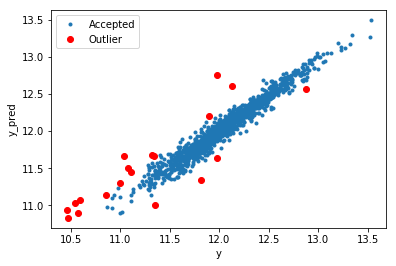

In [14]:
# find and remove outliers using a Ridge model
outliers = find_outliers(Ridge(), df)

# permanently remove these outliers from the data
df_model = df.drop(outliers)

In [16]:
X = df_model.drop("SalePrice", axis=1)
y = np.log(df_model['SalePrice'])

model = Ridge()
model.fit(X,y)
y_pred = pd.Series(model.predict(X), index=y.index)

print('Correlation:', np.corrcoef(y,y_pred)[0][1])
print('R2=',model.score(X,y))
print('rmse=',mean_absolute_error(y, y_pred))

Correlation: 0.9814716471008289
R2= 0.9632687458251801
rmse= 0.055460424577453954


## Fit and Optimise Models

Linear Regression:

* sklearn.linear_model.Ridge
* sklearn.linear_model.Lasso
* sklearn.linear_model.ElasticNet

Support Vector Machines:

* sklearn.svm.LinearSVR
* sklearn.svm.SVR

Nearest Neighbours:

* sklearn.neighbors.KNearestNeighborsRegressor

Tree Based:

* sklearn.ensemble.RandomForestRegressor
* sklearn.ensemble.GradientBoostingRegressor
* xgboost.XGBRegressor

In [9]:
def train_model(model, param_grid=[], X=[], y=[], splits=5, repeats=5):
   
    rkfold = RepeatedKFold(n_splits=splits, n_repeats=repeats)
    
    # perform a grid search if param_grid given
    if len(param_grid)>0:
        gsearch = GridSearchCV(model, param_grid, cv=rkfold,
                               scoring='neg_mean_absolute_error', n_jobs = 8,
                               verbose=1, return_train_score=True)
        gsearch.fit(X,y)

        model = gsearch.best_estimator_        
        best_idx = gsearch.best_index_

        grid_results = pd.DataFrame(gsearch.cv_results_)       
        cv_mean = abs(grid_results.loc[best_idx,'mean_test_score'])
        cv_std = grid_results.loc[best_idx,'std_test_score']

    # no grid search, just cross-val score for given model    
    else:
        grid_results = []
        cv_results = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=rkfold)
        cv_mean = abs(np.mean(cv_results))
        cv_std = np.std(cv_results)

    y_pred = model.predict(X)
    
    # print stats on model performance         
    print('----------------------')
    print(model)
    print('----------------------')
    print('Correlation:', np.corrcoef(y,y_pred)[0][1])
    print('R2=',model.score(X,y))
    print('rmse=',mean_absolute_error(y, y_pred))
    print('cross_val: mean=',cv_mean,', std=',cv_std)
    
    
    
    return model, grid_results

## ElasticNet

In [18]:
en_int = ElasticNet()

param_grid = {'alpha': np.arange(1e-4,1e-3,1e-4),
              'l1_ratio': np.arange(0.1,1.0,0.1),
              'max_iter':[100000]}

# param_grid = {'l1_ratio': np.arange(0.1,1.0,0.1),
#               'max_iter':[100000]}

en_int, grid_results = train_model(en_int, X=X, y=y, param_grid=param_grid, splits=5, repeats=1)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
----------------------
ElasticNet(alpha=0.0004, copy_X=True, fit_intercept=True, l1_ratio=0.9,
      max_iter=100000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Correlation: 0.9736281907947597
R2= 0.9479347232669106
rmse= 0.0669953327081602
cross_val: mean= 0.07380454712979753 , std= 0.0031932122104661904


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   16.6s
[Parallel(n_jobs=8)]: Done 405 out of 405 | elapsed:   23.3s finished


## Random Forest Regression

In [17]:
rfr = RandomForestRegressor()

param_grid = {'n_estimators':[100,150,200],
              'max_features':[25,50,75],
              'min_samples_split':[2,4,6]}

rfr, grid_results = train_model(rfr, X=X, y=y,param_grid=param_grid, 
                                              splits=5, repeats=1)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=75, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)
----------------------
Correlation: 0.9949262251431482
R2= 0.9870952256382878
rmse= 0.031135445053697107
cross_val: mean= 0.08481487732403423 , std= 0.0028683554643976787


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.5s
[Parallel(n_jobs=8)]: Done 135 out of 135 | elapsed:   20.1s finished
